<a href="https://colab.research.google.com/github/abubakrsiddq/ImageDehazing/blob/main/models/unsupervised/unsupervised_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam



In [2]:


from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (412, 548), antialias = True)
    img = img / 255.0
    return img

In [ ]:
def dataset_preposses(orig_path='/content/drive/MyDrive/dataset/clear_images',haze_path='/content/drive/MyDrive/dataset/haze',percentage=0.10,validation_size=64,test_size=64,seed_val=200):
  '''
  parameters:
  orig_path(string): path of ground truth folder
  haze_path(string): path of haze folder
  percentage(float): percentage of dataset to load
  validation_size(int): the no. of validation images
  test_size(int): the no. of test images

  returns:
  haze_list,validation_list,test_list
  '''
  random.seed(seed_val)
  pth=haze_path+'/*.jpg'
  haze_path_list = glob.glob(pth)
  orig_path_list=glob.glob(orig_path+'/*.jpg')
  #print(orig_path_list)
  random.shuffle(haze_path_list)
  #print(haze_path_list)
  haze_path_dict={}
  haze_count_dict={}
  haze_list=[]
  no_per_set=int(percentage*35)
  for i in haze_path_list:
    name=i.split('/')[-1].split('_')[0]
    if(int(name)>468):
      try:
        if(haze_count_dict[name]<no_per_set):
          haze_path_dict[name].append(i)
          
          haze_count_dict[name]+=1;
          
      except KeyError:
       
        haze_path_dict[name]=[]
        haze_path_dict[name].append(i)
        haze_count_dict[name]=1
    #print(haze_path_dict)
  test_list=haze_path_list[-1*test_size:]
  val_list=haze_path_list[-1*(validation_size+test_size):-1*test_size];

  for (key,val) in haze_path_dict.items():
    for i in val:
      haze_list.append(i)
  return haze_list,val_list,test_list


def gen_dataset(ar):
  '''
  parameters
  list of paths
  return
  list with gt attached 
  '''
  orig_path='/content/drive/MyDrive/dataset/clear_images'
  haze_pth='/content/drive/MyDrive/dataset/haze'
  lst=[]
  for i in ar:
    name=i.split('/')[-1].split('_')[0]
    pthlist=[i,orig_path+'/'+name+'.jpg']
    lst.append(pthlist)
  return lst

def data_path(orig_img_path = './drive/MyDrive/reside/archive/clear_images', hazy_img_path = './drive/MyDrive/reside/archive/haze'):
  
  (a,b,c)=dataset_preposses(orig_path=orig_img_path,haze_path=hazy_img_path)
  a=gen_dataset(a)
  b=gen_dataset(b)
  return a,b

In [ ]:
def dataloader(train_data, val_data, batch_size):
    print(len(train_data))
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    return train, val

In [ ]:
def display_img(model, hazy_img, orig_img):
    
    dehazed_img = model(hazy_img,0,training = False)
    plt.figure(figsize = (15,15))
    
    display_list = [hazy_img[0], orig_img[0], dehazed_img[0]]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        directory='/content/drive/MyDrive/Test/padCheck'
        os.chdir(directory)
        filename=str(i)+'.jpg'
        tf.keras.preprocessing.image.save_img(filename,display_list[i])
        
    plt.show()

In [ ]:
class T_net(tf.keras.Model):
  def __init__(self):
    super(T_net,self).__init__()
    self.conv1=Conv2D(input_shape = (413, 550, 3), filters = 3, kernel_size = 1, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv2=Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv3 = Conv2D(filters = 3, kernel_size = 5, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv4 = Conv2D(filters = 3, kernel_size = 7, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv5 = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    
    

  def call(self,inputs):   
    #inputs = tf.keras.Input(shape = [413,550,3])
    #pad=tf.keras.layers.ZeroPadding2D(padding=(1, 1))(inputs)
    #atm=self.get_dark_channel(inputs,15)
    #atm=self.atmlight(inputs,atm)
    conv1 = self.conv1(inputs)
    
    conv2 = self.conv2(conv1)
    concat1 = tf.concat([conv1,conv2], axis = -1)
    
    conv3 = self.conv3(concat1)
    concat2 = tf.concat([conv2,conv3], axis = -1)
    
    conv4 = self.conv4(concat2)
    concat3 = tf.concat([conv1,conv2,conv3,conv4], axis = -1)
    
    conv5 = self.conv5(concat3)
    K = conv5
    output = ReLU(max_value = 1.0)(K)#(tf.math.multiply(K,inputs) - K + 1.0)
    #output1=tf.image.resize_with_crop_or_pad(output1, 412, 548)
    #output=tf.image.resize(output1, size = (413, 550), antialias = True)
    #model = Model(inputs = x, outputs = output)
    
    return output

  def model(self):
        x = Input(shape = (412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))

    
  def build_graph(self):
        x = Input(shape=(412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 412, 548, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 412, 548, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 412, 548, 3)  84          conv2d[0][0]                     
__________________________________________________________________________________________________
tf.concat (TFOpLambda)          (None, 412, 548, 6)  0           conv2d[0][0]                     
                                                                 conv2d_1[0][0]               

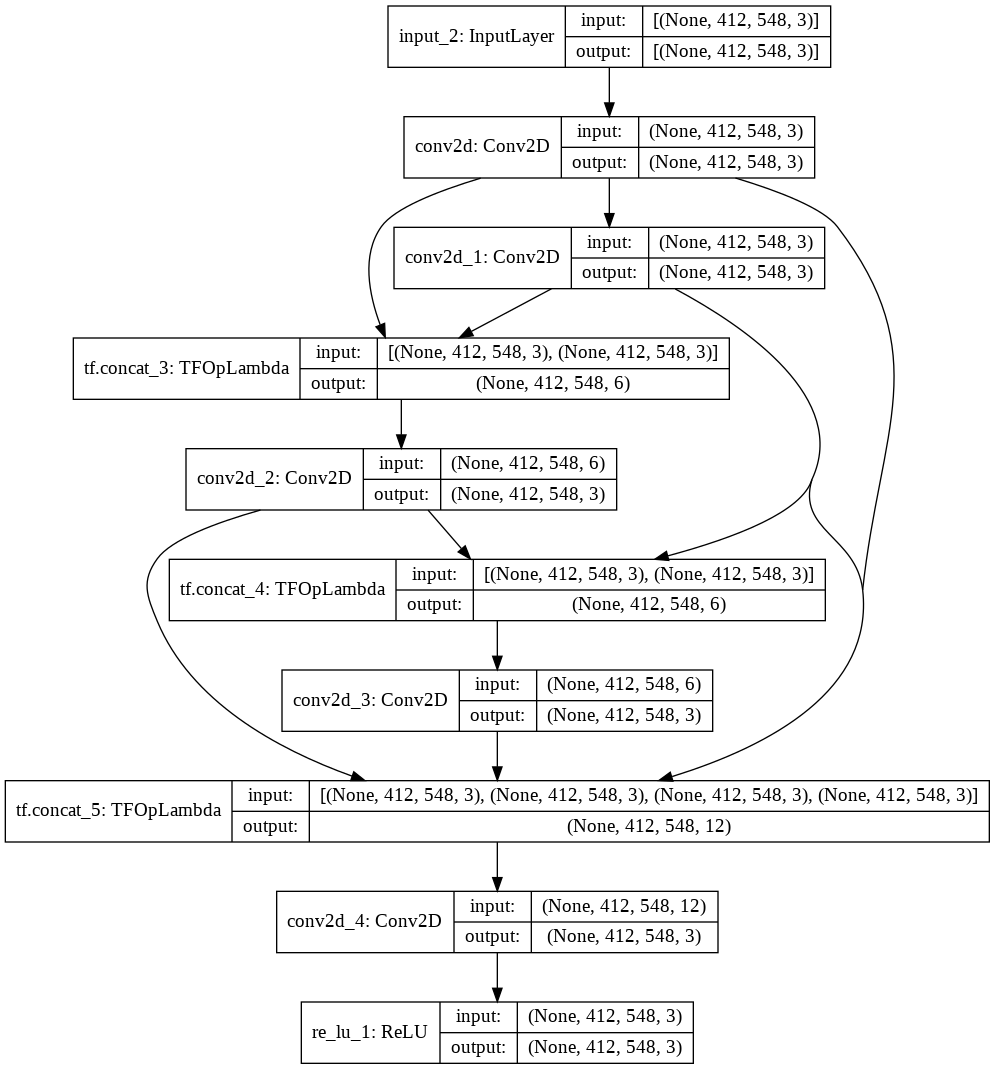

In [ ]:


model=T_net()

model.model().summary()
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model.build_graph(), to_file=dot_img_file, show_shapes=True)



In [ ]:
class A_net(tf.keras.Model):
  
  def __init__(self):
    super(A_net,self).__init__()
    self.conv=Conv2D(filters = 50, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu',)
    self.conv1=Conv2D(filters = 50, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')
    self.dens1=Dense(10,activation='relu')
    self.dens2=Dense(10,activation='relu')
    self.deconv1=Conv2DTranspose(50,kernel_size=(3,3),padding='same',activation='relu')
    self.deconv2=Conv2DTranspose(50,kernel_size=(3,3),padding='same',activation='relu')
    self.deconv3=Conv2DTranspose(3,kernel_size=(3,3),padding='same',activation='linear')

  def call(self,inputs):   
      #inputs = tf.keras.Input(shape = [412,548, 3])     # height, width of input image changed because of error in output
      conv =self.conv(inputs)
      poolLayer=AveragePooling2D(pool_size=(2,2))(conv)
      conv1 =self.conv1(poolLayer)
      poolLayer=AveragePooling2D(pool_size=(2,2))(conv1)  
      #flat=Flatten()(poolLayer)
      dens1=self.dens1(poolLayer)
      dens2=self.dens2(dens1)
      deconv1=self.deconv1(dens2)
      upsamp1=UpSampling2D(size=(2,2))(deconv1)
      deconv2=self.deconv2(upsamp1)
      upsamp2=UpSampling2D(size=(2,2))(deconv2)
      deconv3=self.deconv3(upsamp2)
      output = deconv3

      return deconv3

  def model(self):
        x = Input(shape = (412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))

    
  def build_graph(self):
        x = Input(shape=(412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))



Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 412, 548, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 412, 548, 50)      1400      
_________________________________________________________________
average_pooling2d (AveragePo (None, 206, 274, 50)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 206, 274, 50)      22550     
_________________________________________________________________
average_pooling2d_1 (Average (None, 103, 137, 50)      0         
_________________________________________________________________
dense (Dense)                (None, 103, 137, 10)      510       
_________________________________________________________________
dense_1 (Dense)              (None, 103, 137, 10)      110 

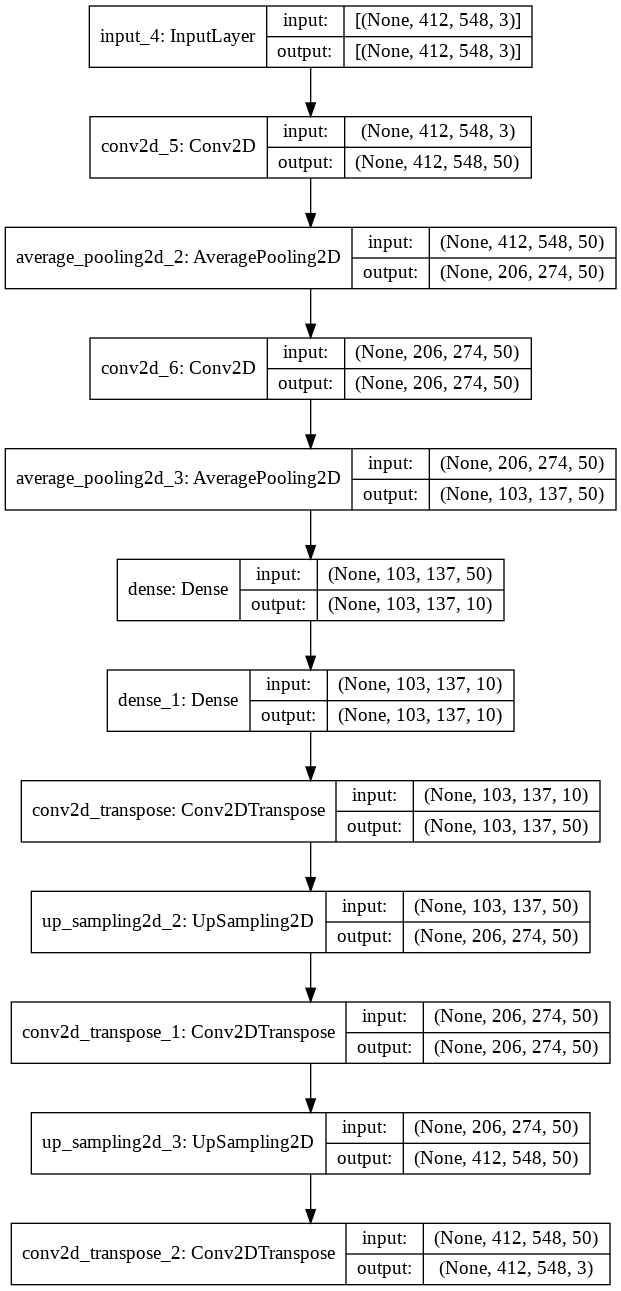

In [ ]:
model=A_net()

model.model().summary()
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model.build_graph(), to_file=dot_img_file, show_shapes=True)

In [ ]:
class Unsuper_net(tf.keras.Model):
  def __init__(self):
    super(Unsuper_net,self).__init__()
    self.t_net=T_net()
    self.a_net=A_net()

  def call(self,haze,gt=0,training=True):
    a=self.a_net(haze)
    t=self.t_net(haze)
    if training is True:
      
      j=gt
      #print(j.shape)
      #x=tf.keras.layers.Concatenate(axis=-1)([a,t,j])
      x=tf.add(tf.multiply(j,t),tf.multiply(a,(1-t)))
      return x
   
    else:
      return  tf.add(tf.math.divide_no_nan(tf.add(haze,-(a)),t),a)   

  def model(self):
        x = Input(shape = (412, 548, 3))
        y = Input(shape = (412, 548, 3))
        return Model(inputs=[x,y], outputs=self.call(x,y))

    
  def build_graph(self):
        x = Input(shape=(412, 548, 3))
        y = Input(shape = (412, 548, 3))
        return Model(inputs=[x,y], outputs=self.call(x,y))


In [ ]:

model=Unsuper_net()

model.model().summary()
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model.build_graph(), to_file=dot_img_file, show_shapes=True)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 412, 548, 3) 0                                            
__________________________________________________________________________________________________
t_net_1 (T_net)                 (None, 412, 548, 3)  1761        input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 412, 548, 3) 0                                            
__________________________________________________________________________________________________
a_net_1 (A_net)                 (None, 412, 548, 3)  53023       input_5[0][0]                    
____________________________________________________________________________________________

AttributeError: ignored

In [ ]:
# Hyperparameters
epochs = 25
batch_size = 16
k_init = tf.keras.initializers.random_normal(stddev=0.008, seed = 101)      
regularizer = tf.keras.regularizers.L2(1e-4)
b_init = tf.constant_initializer()

#train_data, val_data = data_path(orig_img_path = './drive/MyDrive/reside/archive/clear_images', hazy_img_path = './drive/MyDrive/reside/archive/haze')
train_data, val_data = data_path(orig_img_path = '/content/drive/MyDrive/dataset/clear_images', hazy_img_path = '/content/drive/MyDrive/dataset/haze')
#train_data, val_data = data_path()
train, val = dataloader(train_data, val_data, batch_size)

optimizer = Adam(learning_rate = 1e-4)
#net =dehaze_net()
net=Unsuper_net()
#net= tf.keras.models.load_model('/content/drive/MyDrive/nets/dehazenet',compile=False)
train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")

1116


In [ ]:
def train_model(epochs, train, val,net,train_loss_tracker,val_loss_tracker, optimizer):
    t_net=T_net()
    a_net=A_net()
    
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()
        
        # training loop
        
        for step, (train_batch_haze, train_batch_orig) in enumerate(train):

            with tf.GradientTape() as tape:

                #train_logits = net(train_batch_haze,train_batch_orig,training = True)
                #t=t_net(train_batch_haze)
                #a=a_net(train_batch_haze)
                #out=tf.add(tf.multiply(train_batch_orig,t),tf.multiply(a,(1-t)))
                train_logits=net(train_batch_haze,train_batch_orig,training=True)
                loss = mean_squared_error(train_batch_haze,train_logits)
                #loss=tf.math.reduce_mean(loss,axis=None)
                #er=tf.keras.losses.MeanAbsoluteError(tf.keras.losses.Reduction.AUTO)
                #loss=er(train_batch_orig, train_logits)/batch_size
                #loss=tf.image.psnr(train_batch_orig, train_logits, max_val=1)
                #loss=tf.image.ssim(train_batch_orig, train_logits, max_val=1, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
                #loss=custom_loss(train_batch_haze,out)
                #loss=tf.math.reduce_mean(loss)
                #print(loss)

            grads = tape.gradient(loss,net.trainable_weights)
            #grads2 = tape.gradient(loss,a_net.trainable_weights)
            #optimizer.apply_gradients(zip(grads, t_net.trainable_weights))
            optimizer.apply_gradients(zip(grads, net.trainable_weights))

            train_loss_tracker.update_state(train_batch_orig, train_logits)
            if step == 0:
                print('[', end='')
            if step % 64 == 0:
                print('=', end='')
        
        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')
        
        # validation loop
        
        for step, (val_batch_haze, val_batch_orig) in enumerate(val):
            val_logits = net(val_batch_haze,0,False)
            val_loss_tracker.update_state(val_batch_orig, val_logits)
            
            if step % 32 ==0:
                display_img(net, val_batch_haze, val_batch_orig)
        
        print('  -  ', end='')
        print('Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))
        
        #net.save('trained_model')           # save the model(variables, weights, etc)
        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()


Start of epoch 0 [==]  -  Training Loss: 0.1637

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


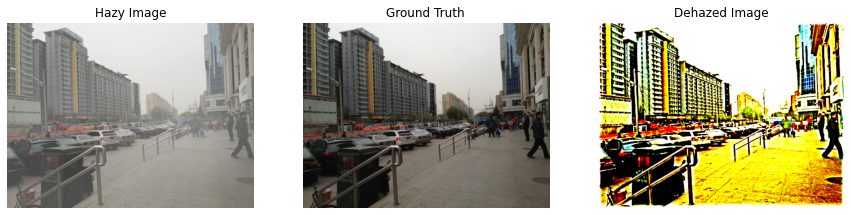

  -  Validation Loss: 7.2397  -   Time taken: 586.86s

Start of epoch 1 [==]  -  Training Loss: 0.0405

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


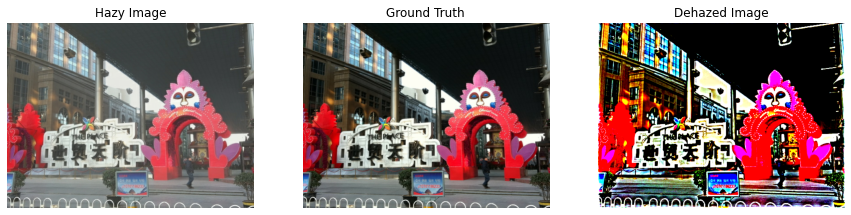

  -  Validation Loss: 1.0976  -   Time taken: 70.49s

Start of epoch 2 [==]  -  Training Loss: 0.0325

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


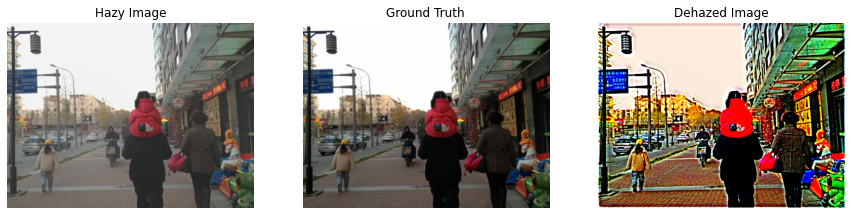

  -  Validation Loss: 0.2083  -   Time taken: 69.94s

Start of epoch 3 [==]  -  Training Loss: 0.0285

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


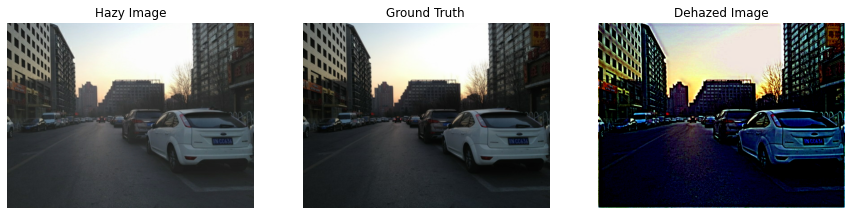

  -  Validation Loss: 0.0589  -   Time taken: 69.86s

Start of epoch 4 [==]  -  Training Loss: 0.0266

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


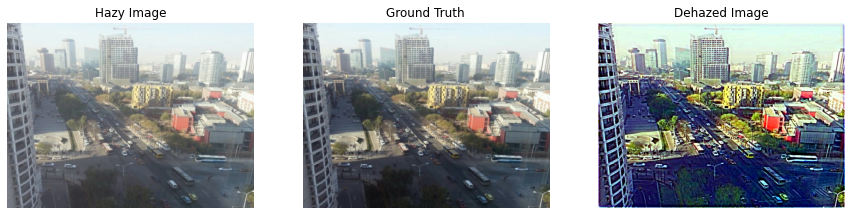

  -  Validation Loss: 0.0450  -   Time taken: 70.12s

Start of epoch 5 [==]  -  Training Loss: 0.0266

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


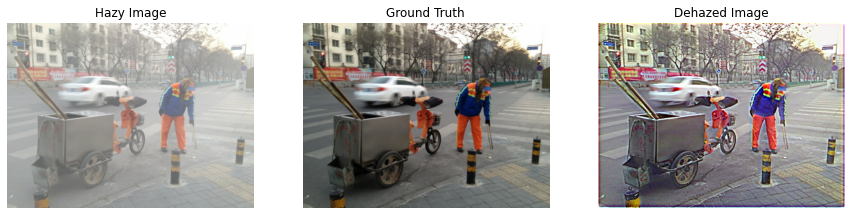

  -  Validation Loss: 0.0374  -   Time taken: 70.12s

Start of epoch 6 [==]  -  Training Loss: 0.0269

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


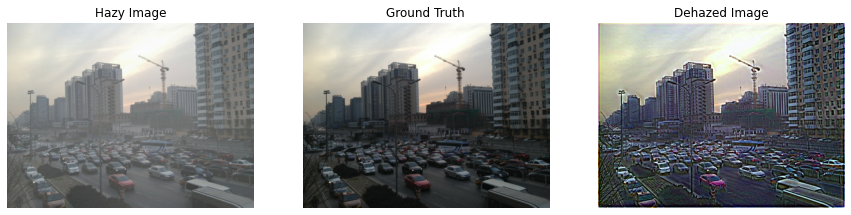

  -  Validation Loss: 0.0361  -   Time taken: 70.06s

Start of epoch 7 [==]  -  Training Loss: 0.0271

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


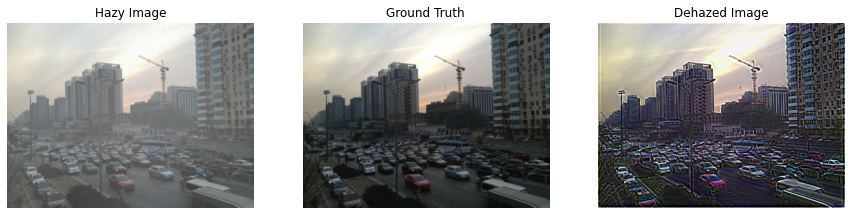

  -  Validation Loss: 0.0312  -   Time taken: 69.95s

Start of epoch 8 [==]  -  Training Loss: 0.0272

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


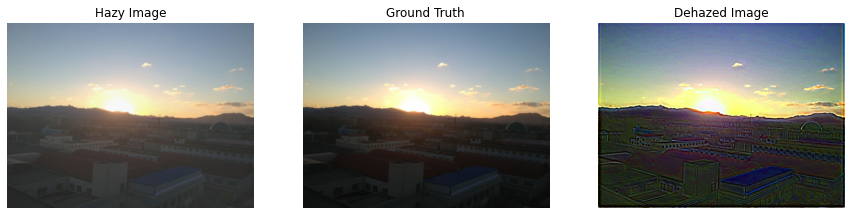

  -  Validation Loss: 0.0313  -   Time taken: 70.63s

Start of epoch 9 [==]  -  Training Loss: 0.0272

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


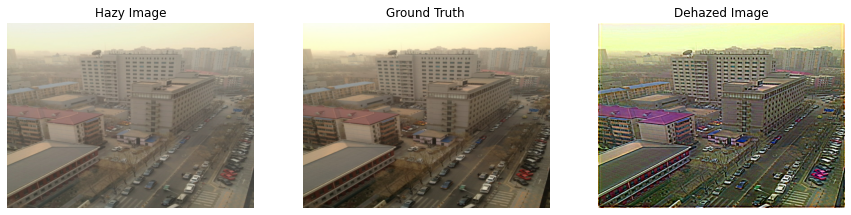

  -  Validation Loss: 0.0298  -   Time taken: 70.39s

Start of epoch 10 [==]  -  Training Loss: 0.0272

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


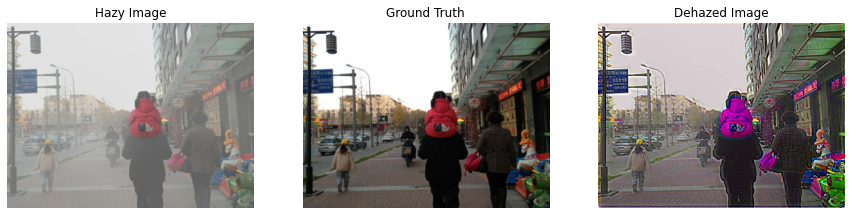

  -  Validation Loss: 0.0258  -   Time taken: 70.18s

Start of epoch 11 [==]  -  Training Loss: 0.0274

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


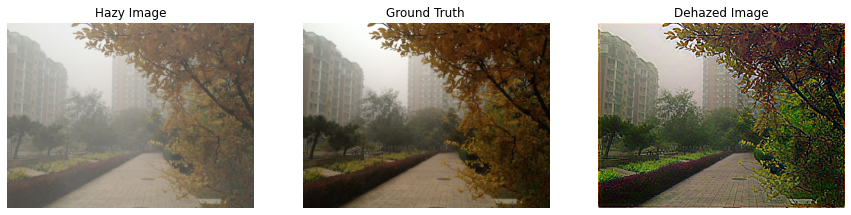

  -  Validation Loss: 0.0270  -   Time taken: 70.07s

Start of epoch 12 [==]  -  Training Loss: 0.0274

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


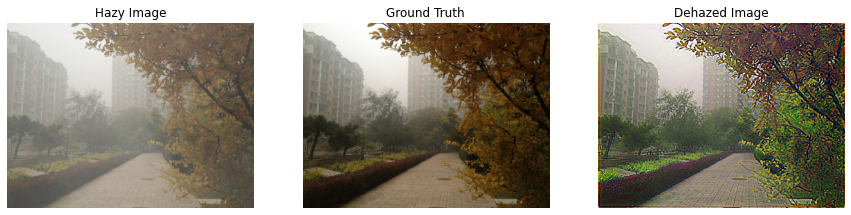

  -  Validation Loss: 0.0229  -   Time taken: 70.17s

Start of epoch 13 [==]  -  Training Loss: 0.0274

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


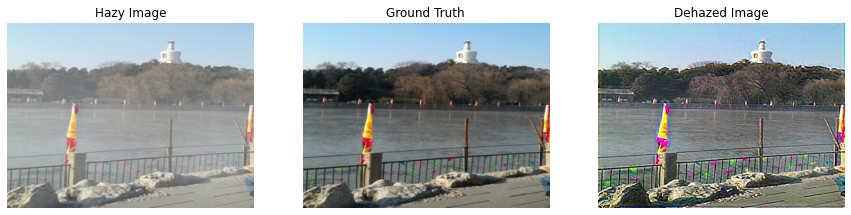

  -  Validation Loss: 0.0217  -   Time taken: 70.26s

Start of epoch 14 [==]  -  Training Loss: 0.0273

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


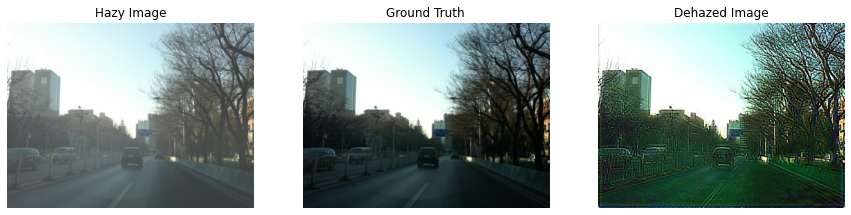

  -  Validation Loss: 0.0219  -   Time taken: 70.14s

Start of epoch 15 [==]  -  Training Loss: 0.0273

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


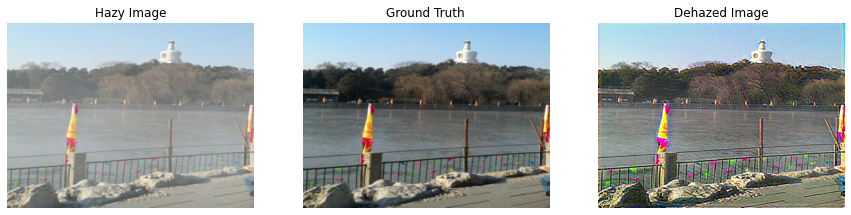

  -  Validation Loss: 0.0226  -   Time taken: 70.31s

Start of epoch 16 [==]  -  Training Loss: 0.0275

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


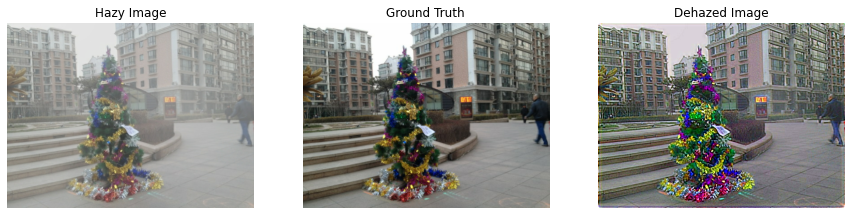

  -  Validation Loss: 0.0223  -   Time taken: 70.07s

Start of epoch 17 [==]  -  Training Loss: 0.0274

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


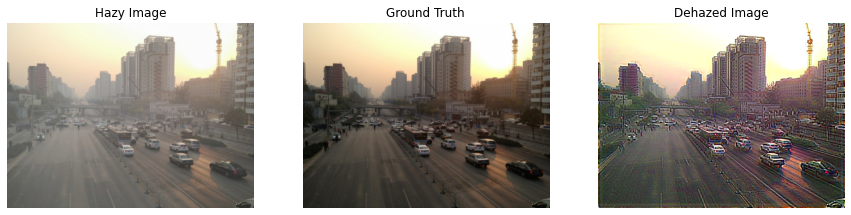

  -  Validation Loss: 0.0271  -   Time taken: 70.07s

Start of epoch 18 [==]  -  Training Loss: 0.0274

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


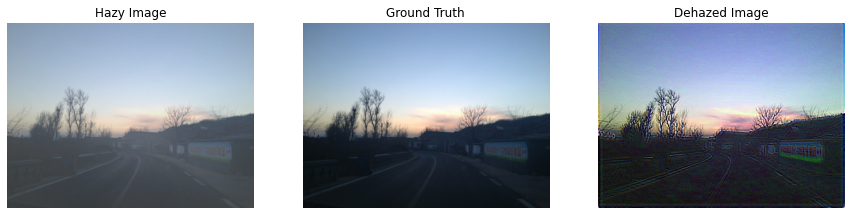

  -  Validation Loss: 0.0221  -   Time taken: 70.13s

Start of epoch 19 [==]  -  Training Loss: 0.0274

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


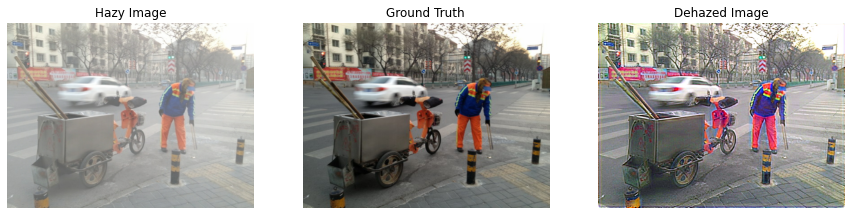

  -  Validation Loss: 0.0218  -   Time taken: 70.32s

Start of epoch 20 [==]  -  Training Loss: 0.0274

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


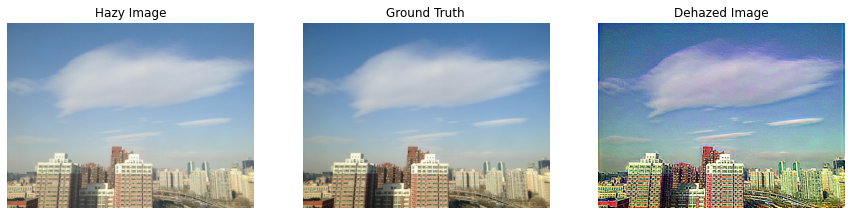

  -  Validation Loss: 0.0222  -   Time taken: 70.30s

Start of epoch 21 [==]  -  Training Loss: 0.0274

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


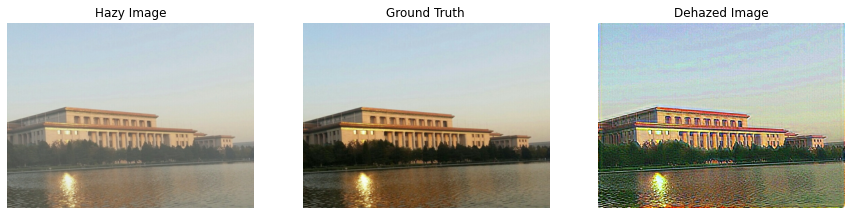

  -  Validation Loss: 0.0234  -   Time taken: 71.04s

Start of epoch 22 [==]  -  Training Loss: 0.0275

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


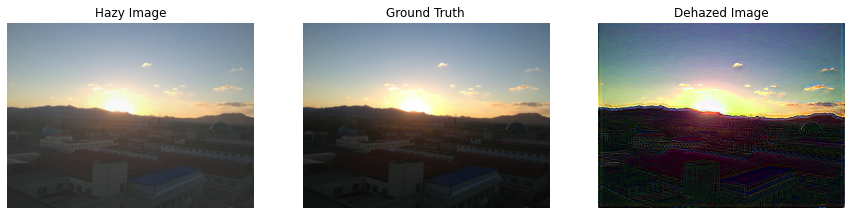

  -  Validation Loss: 0.0227  -   Time taken: 70.57s

Start of epoch 23 [==]  -  Training Loss: 0.0275

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


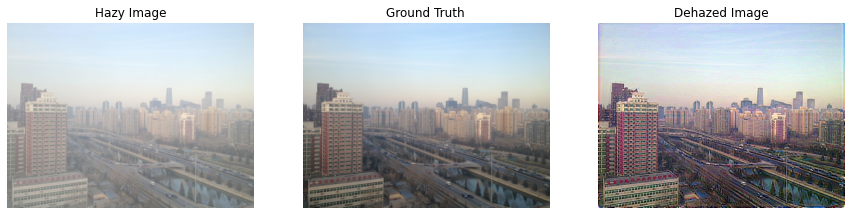

  -  Validation Loss: 0.0237  -   Time taken: 70.41s

Start of epoch 24 [==]  -  Training Loss: 0.0275

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


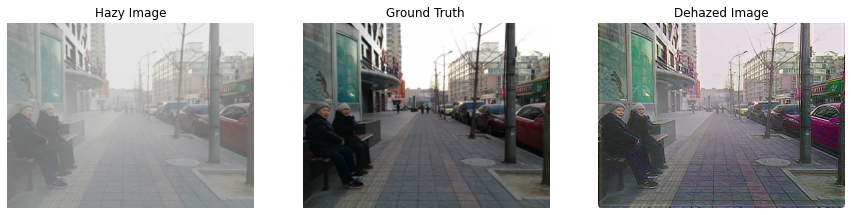

  -  Validation Loss: 0.0226  -   Time taken: 70.81s
CPU times: user 13min 43s, sys: 52.9 s, total: 14min 36s
Wall time: 37min 53s


In [ ]:
%%time

train_model(epochs, train, val,net,train_loss_tracker, val_loss_tracker, optimizer)

In [ ]:
net.save_weights('/content/drive/MyDrive/nets/lca_dehaze_form/net')

In [ ]:
import cv2
import matplotlib.pyplot as plt

def evaluate_gen(net):
    
    #test_img = glob.glob(test_img_path +'/*.jpg')
    test_img=glob.glob('/content/drive/MyDrive/Final_compare/HAZY/*.jpg')
    #random.shuffle(test_img)
    i=0;
    for img in test_img:
        
        img = tf.io.read_file(img)
        img = tf.io.decode_jpeg(img, channels = 3)
        
        img = tf.image.resize(img, size = (412,548), antialias = True)
        
        img = img / 255.0
        print(i,end=" ")
        img = tf.expand_dims(img, axis = 0)      #transform input image from 3D to 4D ###
        
        dehaze = net(img,0,False)
        dehaze=dehaze*255.0
        #plt.figure(figsize = (80, 80))
        
        #display_list = [img[0], dehaze[0]]       #make the first dimension zero
        im=dehaze[0]
        directory = '/content/drive/MyDrive/Final_compare/lca_dehaze_form'
        os.chdir(directory)
        filename = str(i) + '_outdoor_gen.jpg'
        #print(filename)
        #cv2.imwrite(filename,im) 
        #plt.imsave(filename,im)
        #tf.keras.preprocessing.image.save_img(
    #filename, im)
        #plt.imsave(filename,im)
        plt.imshow(im)
        os.chdir('/content')
        i+=1;
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 1 2 3 4 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 6 7 8 9 10 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11 12 13 14 15 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16 17 18 19 20 21 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22 23 24 25 26 27 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


28 29 30 31 32 33 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


34 35 36 37 38 39 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


40 41 

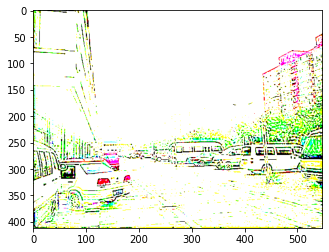

In [ ]:
#new_model = tf.keras.models.load_model('/content/drive/MyDrive/nets/dehazenet',compile=False)
#new_model = tf.keras.models.load_model('/content/drive/MyDrive/nets/dehazenet/trained_model',compile=False)

evaluate_gen(net)



In [3]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (412, 548), antialias = True)
    img = img / 255.0
    return img

In [37]:
a=load_image('/content/drive/MyDrive/Test/padCheck/2.jpg')

In [38]:
b=load_image('/content/drive/MyDrive/Test/padCheck/1.jpg')

In [49]:
a1=a.numpy()


In [53]:
a1.max()

1.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


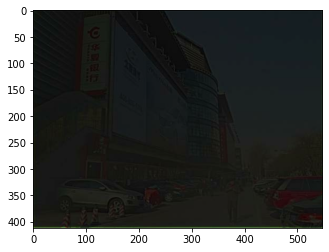

In [51]:
plt.imshow(a1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


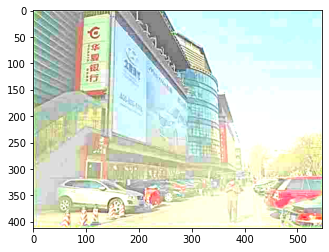

In [52]:
plt.imshow(a)

In [40]:
a1=a1.flatten()
b1=b.numpy().flatten()

In [41]:
histogram, bin_edges = np.histogram(a1, bins=256, range=(0, 1))
histogram1, bin_edges1 = np.histogram(b1, bins=256, range=(0, 1))

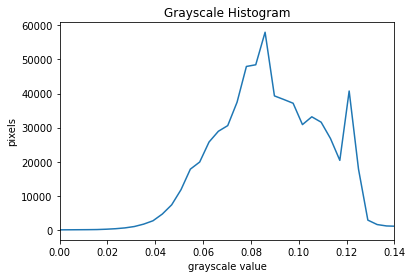

In [47]:
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim([0.0, 0.140])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()

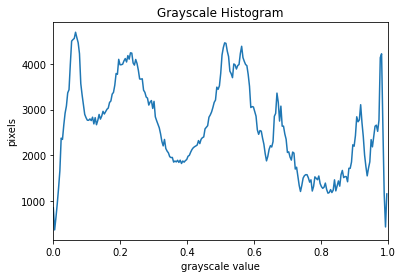

In [43]:
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim([0.0, 1.0])  # <- named arguments do not work here

plt.plot(bin_edges1[0:-1], histogram1)  # <- or here
plt.show()

In [48]:
a=a/(0.135-0.04)-0.04